# Understanding errors in analysis increments

## Preliminaries

### Load packages

In [63]:
import numpy as np
from numpy.linalg import norm
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
cd /Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts


In [6]:
from post_processing_fns import *
from letkf import *

In [7]:
which_columns2 = {
  'lons' : [-154.5, 35.5, 75.5, -150.5, 160.5],
  'lats' : [-27.5, -49.5, -31.5, 12.5, 40.5],
  'name' : ['South Pacific', 'Southern Ocean', 'Indian Ocean', 'Tropical Pacific', 'North Pacific'],
  'save_name' : ['south_pacific2', 'southern_ocean2', 'indian_ocean2', 'tropical_pacific2', 'north_pacific']
}

In [8]:
these_columns = which_columns2

In [37]:
## Where are we working
proj_dir = '/Users/zstanley/Documents/git_repos/obs_loc_for_scda'
plot_dir = proj_dir + '/plots/understanding_metrics/analysis_cov/'
my_data_dir = proj_dir + '/my_data/20151206.030000'
nb_dir = proj_dir + '/notebooks'

### Load data

In [10]:
## Load vertical columns
south_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][0]+'.nc')
southern_ocean = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][1]+'.nc')
indian_ocean = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][2]+'.nc')
tropical_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][3]+'.nc')
north_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][4]+'.nc')

In [11]:
# Load covariance matrices
sp_cov = np.load(my_data_dir +'/'+these_columns['save_name'][0]+'_cov.npy')
so_cov = np.load(my_data_dir +'/'+these_columns['save_name'][1]+'_cov.npy')
io_cov = np.load(my_data_dir +'/'+these_columns['save_name'][2]+'_cov.npy')
tp_cov = np.load(my_data_dir +'/'+these_columns['save_name'][3]+'_cov.npy')
np_cov = np.load(my_data_dir +'/'+these_columns['save_name'][4]+'_cov.npy')

In [12]:
# Load correlation matrices
sp_cor = np.load(my_data_dir +'/'+these_columns['save_name'][0]+'_cor.npy')
so_cor = np.load(my_data_dir +'/'+these_columns['save_name'][1]+'_cor.npy')
io_cor = np.load(my_data_dir +'/'+these_columns['save_name'][2]+'_cor.npy')
tp_cor = np.load(my_data_dir +'/'+these_columns['save_name'][3]+'_cor.npy')
np_cor = np.load(my_data_dir +'/'+these_columns['save_name'][4]+'_cor.npy')

### Process data

In [13]:
# Compute atm pressure from pressure thickness of each level
south_pacific['atm_p'] = south_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
southern_ocean['atm_p'] = southern_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
indian_ocean['atm_p'] = indian_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
tropical_pacific['atm_p'] = tropical_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
north_pacific['atm_p'] = north_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2

In [14]:
## Get indices of relevant pressure levels in atm and depth levels in ocn
# atmosphere
num_atm_levs = len(south_pacific['atm_lev'])
ind_ast = num_atm_levs - 1
ind100hPa = np.argmin(np.abs(south_pacific['atm_p'].mean(['lat', 'lon']).values-100))
ind800hPa = np.argmin(np.abs(south_pacific['atm_p'].mean(['lat', 'lon']).values-800))
# ocean
ind0m = num_atm_levs
ind150m_ocn = np.argmin(np.abs(south_pacific['ocn_lev'].values-150))
ind2km_ocn  = np.argmin(np.abs(south_pacific['ocn_lev'].values-2000))
num_ocn_levs = len(south_pacific['ocn_lev'])
# both
ind150m = ind0m + ind150m_ocn
ind2km = ind0m + ind2km_ocn
num_tot_levs = num_atm_levs + num_ocn_levs

In [15]:
def get_column_mean(ds):
    # initialize array
    num_atm_levs = len(ds['atm_lev'])
    num_ocn_levs = len(ds['ocn_lev'])
    num_tot_levs = num_atm_levs + num_ocn_levs
    ds_manual = np.empty(num_tot_levs)
    # Get mean of atm bootstrapped ensemble
    ds_atm = ds['atm_T'].mean(['lat', 'lon', 'ens_mem'])
    ds_atm = ds_atm.to_numpy()
    # Get mean of ocn bootstrapped ensemble
    ds_ocn = ds['ocn_Temp'].mean(['lat', 'lon', 'ens_mem'])
    ds_ocn = ds_ocn.to_numpy()
    # Store atm and ocn temperature mean
    ds_manual[:num_atm_levs] = ds_atm - 273.15
    ds_manual[num_atm_levs:num_tot_levs] = ds_ocn
    ds_manual = np.atleast_2d(ds_manual).transpose()
    return ds_manual

In [16]:
# Get mean temperature profiles
sp_avg = get_column_mean(south_pacific)
so_avg = get_column_mean(southern_ocean)
io_avg = get_column_mean(indian_ocean)
tp_avg = get_column_mean(tropical_pacific)
np_avg = get_column_mean(north_pacific)

### Define parameters

In [17]:
# Define a range of localization radii for ocn and atm
loc_rads_ocn = [5, 15, 30, 40, 50, 60, 70, 80, 100, 200]
loc_rads_atm = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]
loc_rads_crs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 1.5, 2]
loc_rad_noloc = 1e5

## Assimilate AST into ATM

### Plot each part of the metric

In [30]:
def compute_analysis(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, use_loc=True):
    ## Set observation operator
    num_levs = this_cov.shape[0]
    HofX = np.zeros((1, num_levs))
    HofX[0, ind_ob] = 1
    
    ## Generate synthetic observations
    xt = this_avg + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1)) 
    y_ob = HofX @ ( xt + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1))) # obs error set to equal 'perfect' background error
    
    ## Generate ensemble
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_err_ens = this_cov_sqrt @ rnd
    P_ens = np.cov(x_err_ens)
    x_ens = this_avg + x_err_ens

    ## Form background observation perturbations
    y_ens = HofX @ x_ens
    
    ## Set observation error variance equal to true variance
    R = HofX @ this_cov @ HofX.transpose()
    R_inv = np.reciprocal(R)
    
    ## Calculate analysis increments
    background_mean = np.mean(x_ens, 1)
    innovation = y_ob - HofX @ background_mean
    perfect_kg = ( this_cov @ HofX.transpose() /(HofX @ this_cov @ HofX.transpose() + R))
    
    ## Take only state
    x_ens = x_ens[ind_state]
    background_mean = background_mean[ind_state]
    perfect_kg = perfect_kg[ind_state, :]
    pos_state = pos_state[ind_state]
    this_cov = this_cov[np.ix_(ind_state, ind_state)]
    HofX = HofX[:,ind_state] # will have to be more clever than this to deal with cross-fluid assimilation
    P_ens = P_ens[np.ix_(ind_state, ind_state)]
    num_levs = len(ind_state)
    
    ## Get perfect analysis covariance
    Pa_perfect = (np.eye(num_levs)-perfect_kg @ HofX) @ this_cov
    Pb_perfect = this_cov
    
    ## Get analysis mean
    loc_rad_state = np.full_like(pos_state, loc_rads_state)
    Pa_letkf = letkf(x_ens, y_ens, R_inv, y_ob, pos_state, pos_ob, loc_rad_state, loc_rad_ob, inflate=1, use_loc=use_loc)[1]
    
    return Pa_letkf, Pa_perfect, Pb_perfect

In [34]:
def run_multiple_trials(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, num_trials=100, use_loc=True):
    Pa_letkf_multi = np.empty((len(ind_state), len(ind_state), num_trials))
    Pa_letkf, Pa_perfect, Pb_perfect = compute_analysis(ind_state=ind_state, ind_ob=ind_ob, loc_rads_state=loc_rads_state, loc_rad_ob=loc_rad_ob, this_avg=this_avg, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, pos_ob=pos_ob, ens_size=ens_size, use_loc=use_loc)
    Pa_letkf_multi[:, :, 0] = Pa_letkf
    for trial in range(1,num_trials):
        Pa_letkf = compute_analysis(ind_state=ind_state, ind_ob=ind_ob, loc_rads_state=loc_rads_state, loc_rad_ob=loc_rad_ob, this_avg=this_avg, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, pos_ob=pos_ob, ens_size=ens_size, use_loc=use_loc)[0]
        Pa_letkf_multi[:, :, trial] = Pa_letkf
    return Pa_letkf_multi, Pa_perfect, Pb_perfect

In [35]:
# Set inputs for assimilation of ast into atm
ds = south_pacific
ind_state = np.arange(ind100hPa, num_atm_levs)
ind_ob = ind_ast
loc_rads_state = loc_rad_noloc
loc_rad_ob = loc_rad_noloc
this_avg = sp_avg
this_cov = sp_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
atm_p = ds['atm_p'].mean(['lat', 'lon']).to_numpy()
pos_state = np.abs(np.log(atm_p) - np.log(atm_p[-1]))
pos_ob = pos_state[-1]
use_loc = False

In [36]:
Pa_letkf_multi, Pa_perfect, Pb_perfect = run_multiple_trials(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, num_trials=1000, use_loc=use_loc)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


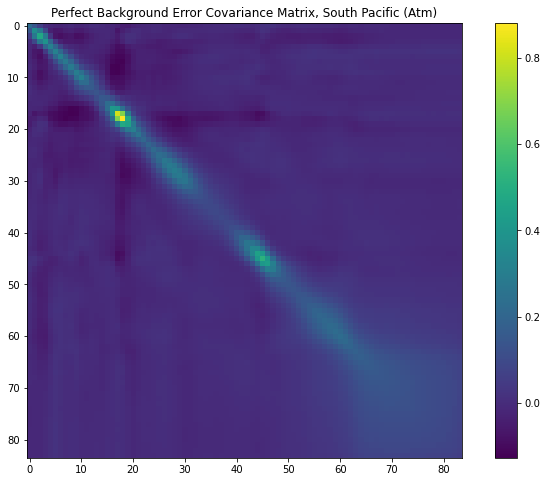

In [48]:
# Plot covariance matrices
this_cov = Pb_perfect
fullname = 'South Pacific'
short_name = 'south_pacific'
plt.imshow(this_cov)
plt.colorbar()
plt.title('Perfect Background Error Covariance Matrix, '+fullname+' (Atm)')
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/background_cov_'+short_name+'.png')

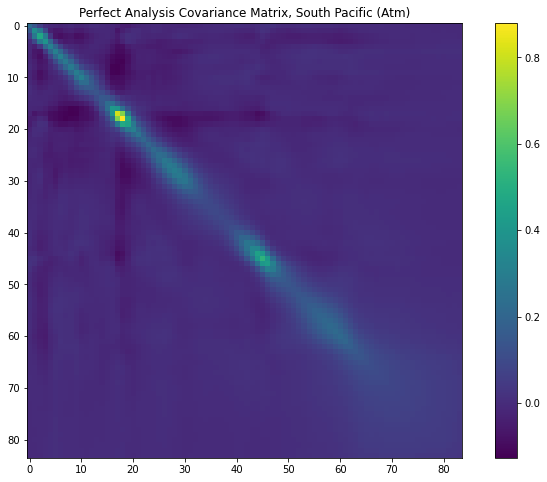

In [49]:
# Plot covariance matrices
this_cov = Pa_perfect
fullname = 'South Pacific'
short_name = 'south_pacific'
plt.imshow(this_cov)
plt.colorbar()
plt.title('Perfect Analysis Covariance Matrix, '+fullname+' (Atm)')
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/analysis_cov_'+short_name+'.png')

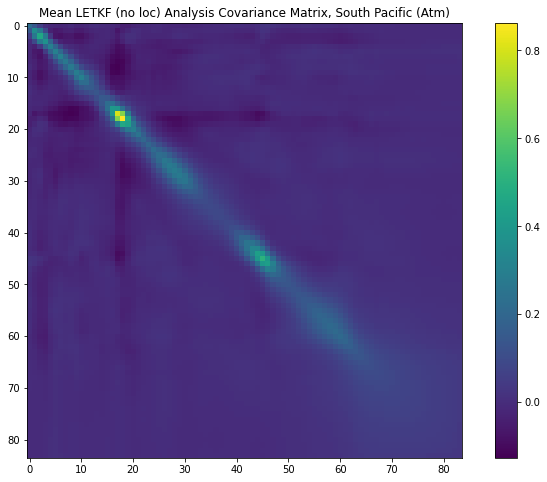

In [52]:
# Plot covariance matrices
this_cov = np.mean(Pa_letkf_multi, axis=2)
fullname = 'South Pacific'
short_name = 'south_pacific'
plt.imshow(this_cov)
plt.colorbar()
plt.title('Mean LETKF (no loc) Analysis Covariance Matrix, '+fullname+' (Atm)')
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/letkf_cov_'+short_name+'.png')

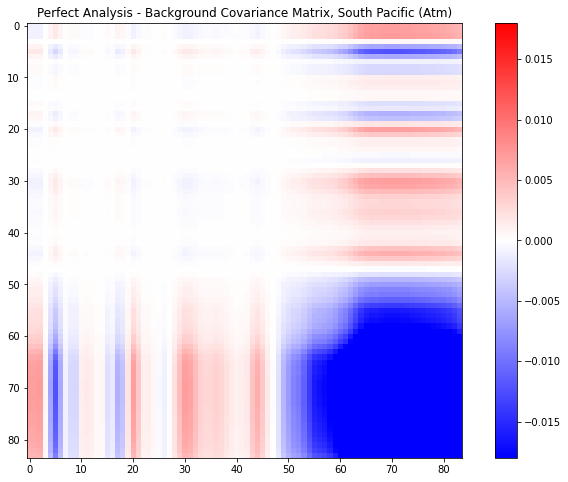

In [62]:
# Plot covariance matrices
this_cov = Pa_perfect - Pb_perfect
fullname = 'South Pacific'
short_name = 'south_pacific'
plt.imshow(this_cov, vmin=-.018, vmax=0.018, cmap='bwr')
plt.colorbar()
plt.title('Perfect Analysis - Background Covariance Matrix, '+fullname+' (Atm)')
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/diff_analysis_background_cov_'+short_name+'.png')

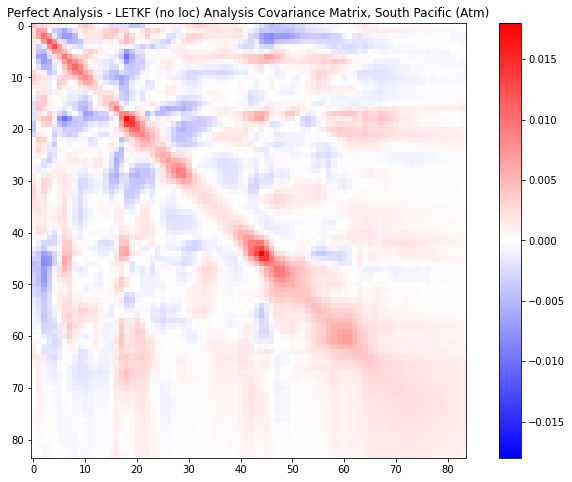

In [60]:
# Plot covariance matrices
this_cov = Pa_perfect - np.mean(Pa_letkf_multi, axis=2)
fullname = 'South Pacific'
short_name = 'south_pacific'
plt.imshow(this_cov, vmin=-.018, vmax=0.018, cmap='bwr')
plt.colorbar()
plt.title('Perfect Analysis - LETKF (no loc) Analysis Covariance Matrix, '+fullname+' (Atm)')
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/diff_analysis_letkf_cov_'+short_name+'.png')

### Plot metric for different localization radii with EnKF and LETKF

In [64]:
def create_distance_matrix(spatial_locations):
    N = len(spatial_locations) 
    # Create distance matrix
    dis = np.zeros((N,N))
    for jj in range(N):
        for ii in range(N):
            d = np.abs(spatial_locations[ii]-spatial_locations[jj])
            dis[ii, jj] = d
    return dis

In [75]:
def compute_relative_error(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, use_loc=True):
    ## Set observation operator
    num_levs = this_cov.shape[0]
    HofX = np.zeros((1, num_levs))
    HofX[0, ind_ob] = 1
    
    ## Generate synthetic observations
    xt = this_avg + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1)) 
    y_ob = HofX @ ( xt + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1))) # obs error set to equal 'perfect' background error
    
    ## Generate ensemble
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_err_ens = this_cov_sqrt @ rnd
    P_ens = np.cov(x_err_ens)
    x_ens = this_avg + x_err_ens

    ## Form background observation perturbations
    y_ens = HofX @ x_ens
    
    ## Set observation error variance equal to true variance
    R = HofX @ this_cov @ HofX.transpose()
    R_inv = np.reciprocal(R)
    
    ## Calculate background mean and innovation
    background_mean = np.mean(x_ens, 1)
    innovation = y_ob - HofX @ background_mean
    
    ## Compute perfect analysis
    perfect_innovation = y_ob - HofX @ this_avg
    perfect_kg = ( this_cov @ HofX.transpose() /(HofX @ this_cov @ HofX.transpose() + R))
    
    ## Take only state
    x_ens = x_ens[ind_state]
    background_mean = background_mean[ind_state]
    perfect_kg = perfect_kg[ind_state, :]
    pos_state = pos_state[ind_state]
    this_cov = this_cov[np.ix_(ind_state, ind_state)]
    HofX = HofX[:,ind_state] # will have to be more clever than this to deal with cross-fluid assimilation
    P_ens = P_ens[np.ix_(ind_state, ind_state)]
    num_levs = len(ind_state)
    
    ## Get perfect analysis covariance
    Pa_perfect = (np.eye(num_levs)-perfect_kg @ HofX) @ this_cov
    Pb_perfect = this_cov
    
    ## Get distance matrix
    dist = create_distance_matrix(pos_state)
    
    ## Get relative error for each localization radius
    num_loc_rads =  len(loc_rads_state)
    norm_rel_error_enkf = np.empty(num_loc_rads)
    norm_rel_error_letkf = np.empty(num_loc_rads)
    for loc_ind in range(num_loc_rads):
        # Get localization radius
        localization_radius = loc_rads_state[loc_ind]
        # EnKF update
        if use_loc:
            loc = gaspari_cohn(dist/(localization_radius/2))
            C = loc * P_ens # Localize ensemble covariance (inefficient, but OK for a small system)
        else:
            C = P_ens 
        enkf_kg = ( C @ HofX.transpose() )/( HofX @ C @ HofX.transpose() + R ) # Bad! But OK for single ob (scalar R)
        Pa_enkf = (np.eye(num_levs)-enkf_kg @ HofX) @ P_ens
        # LETKF update
        loc_rad_state = np.full_like(pos_state, localization_radius)
        Pa_letkf = letkf(x_ens, y_ens, R_inv, y_ob, pos_state, pos_ob, loc_rad_state, loc_rad_ob, inflate=1, use_loc=use_loc)[1]
        # Compute relative error
        Pa_err_enkf = norm(Pa_perfect - Pa_enkf)
        Pa_err_letkf = norm(Pa_perfect - Pa_letkf)
        Pa_err_no_da = norm(Pa_perfect - P_ens)
        # Store relative error
        norm_rel_error_enkf[loc_ind] = Pa_err_enkf/Pa_err_no_da
        norm_rel_error_letkf[loc_ind] = Pa_err_letkf/Pa_err_no_da
    
    return norm_rel_error_enkf, norm_rel_error_letkf

In [76]:
def run_multiple_trials_rel_err(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, num_trials=100, use_loc=True):
    norm_rel_errors_enkf = np.empty((len(loc_rads_state), num_trials))
    norm_rel_errors_letkf = np.empty((len(loc_rads_state), num_trials))
    for trial in range(num_trials):
        norm_rerr_enkf, norm_rerr_letkf = compute_relative_error(ind_state=ind_state, ind_ob=ind_ob, loc_rads_state=loc_rads_state, loc_rad_ob=loc_rad_ob, this_avg=this_avg, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, pos_ob=pos_ob, ens_size=ens_size, use_loc=use_loc)
        norm_rel_errors_enkf[:, trial] = norm_rerr_enkf
        norm_rel_errors_letkf[:, trial] = norm_rerr_letkf
    return norm_rel_errors_enkf, norm_rel_errors_letkf

In [77]:
# Set inputs for assimilation of ast into atm
ds = south_pacific
ind_state = np.arange(ind100hPa, num_atm_levs)
ind_ob = ind_ast
loc_rads_state = loc_rads_atm
loc_rad_ob = loc_rad_noloc
this_avg = sp_avg
this_cov = sp_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
atm_p = ds['atm_p'].mean(['lat', 'lon']).to_numpy()
pos_state = np.abs(np.log(atm_p) - np.log(atm_p[-1]))
pos_ob = pos_state[-1]
use_loc = True

In [78]:
norm_rel_errors_enkf, norm_rel_errors_letkf = run_multiple_trials_rel_err(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, num_trials=1000, use_loc=use_loc)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:44: RuntimeWarning: invalid value encountered in reciprocal
  gc[less2] = 1/12*dist[less2]**5 - .5*dist[less2]**4 + 0.625*dist[less2]**3 + 5/3*dist[less2]**2 - 5*dist[less2] + 4 - 2/3*dist[less2]**-1 ;
/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


In [79]:
norm_rel_errors_enkf_noloc, norm_rel_errors_letkf_noloc = run_multiple_trials_rel_err(ind_state, ind_ob, [loc_rad_noloc], loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, num_trials=1000, use_loc=False)

In [80]:
# Get errors with localization 
for ii in range(norm_rel_errors_enkf.shape[0]):
    data_enkf = {'error': norm_rel_errors_enkf[ii,:], 
                 'loc_rad': loc_rads_state[ii],
                 'da_method': 'EnKF',
                 'localization': True}
    data_letkf = {'error': norm_rel_errors_letkf[ii,:], 
                  'loc_rad': loc_rads_state[ii],
                  'da_method': 'LETKF',
                  'localization': True}
    df_enkf_hold = pd.DataFrame(data_enkf)
    df_letkf_hold = pd.DataFrame(data_letkf)
    if ii == 0:
        df_manual = pd.concat([df_enkf_hold, df_letkf_hold])
    else:
        df_manual = pd.concat([df_manual, df_enkf_hold, df_letkf_hold])
# Get errors without localization
data_enkf = {'error': norm_rel_errors_enkf_noloc[0,:], 
             'loc_rad': np.Inf,
             'da_method': 'EnKF',
             'localization': False}
data_letkf = {'error': norm_rel_errors_letkf_noloc[0,:], 
              'loc_rad': np.Inf,
              'da_method': 'LETKF',
              'localization': False}
df_enkf_hold = pd.DataFrame(data_enkf)
df_letkf_hold = pd.DataFrame(data_letkf)
df_manual = pd.concat([df_manual, df_enkf_hold, df_letkf_hold])

In [82]:
def convert_to_dataarray(loc_rads_state, norm_rel_errors_enkf, norm_rel_errors_letkf, norm_rel_errors_enkf_noloc, norm_rel_errors_letkf_noloc):
    da_enkf = xr.DataArray( data=norm_rel_errors_enkf.T, dims=["trial", "loc_rad"], 
                           coords=dict(trial=np.arange(norm_rel_errors_enkf.shape[1]),loc_rad=loc_rads_state,da_method='EnKF'))
    da_letkf = xr.DataArray( data=norm_rel_errors_letkf.T, dims=["trial", "loc_rad"], 
                           coords=dict(trial=np.arange(norm_rel_errors_enkf.shape[1]),loc_rad=loc_rads_state,da_method='LETKF'))
    da_enkf_noloc = xr.DataArray( data=norm_rel_errors_enkf_noloc[0,:], dims=["trial"], 
                           coords=dict(trial=np.arange(norm_rel_errors_enkf_noloc.shape[1]), loc_rad=np.NAN, da_method='EnKF-NoLoc'))
    da_letkf_noloc = xr.DataArray( data=norm_rel_errors_letkf_noloc[0,:], dims=["trial"], 
                           coords=dict(trial=np.arange(norm_rel_errors_letkf_noloc.shape[1]), loc_rad=np.NAN, da_method='LETKF-NoLoc'))
    da = xr.concat([da_enkf, da_letkf], dim='da_method')
    da_noloc = xr.concat([da_enkf_noloc, da_letkf_noloc], dim='da_method')
    return da, da_noloc

In [83]:
da, da_noloc = convert_to_dataarray(loc_rads_state, norm_rel_errors_enkf, norm_rel_errors_letkf, norm_rel_errors_enkf_noloc, norm_rel_errors_letkf_noloc)

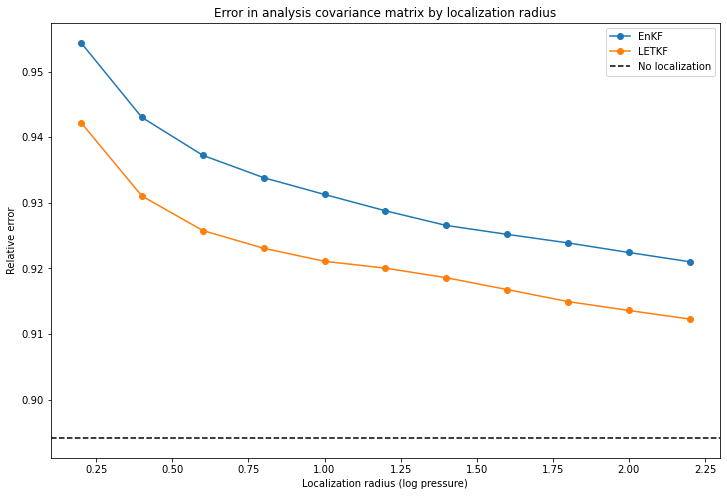

In [84]:
plt.plot(da['loc_rad'], da.sel(da_method='EnKF').median('trial'), '-o', label='EnKF')
plt.plot(da['loc_rad'], da.sel(da_method='LETKF').median('trial'), '-o', label='LETKF')
plt.axhline(y=da_noloc.median(), color='k', linestyle='--', label='No localization')
plt.legend()

# Adjust and label axes
plt.title('Error in analysis covariance matrix by localization radius')
plt.ylabel('Relative error')
plt.xlabel('Localization radius (log pressure)')

# Adjust aesthetics
plt.rcParams['figure.figsize'] = [12,12]

# Save and show
plt.savefig(plot_dir+'/relative_error_by_loc_rad')
plt.show()

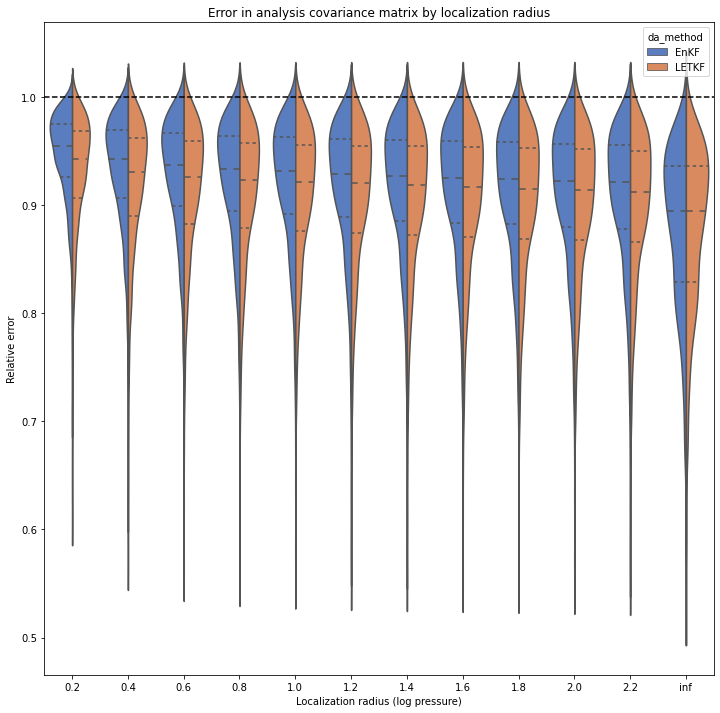

In [85]:
# Violin plots
sns.violinplot(data=df_manual, x='loc_rad', y='error', hue='da_method', split=True, inner='quartiles', palette="muted")
plt.axhline(y=1, color='k', linestyle='--', label='Assim worse than no assim')


# Adjust and label axes
plt.title('Error in analysis covariance matrix by localization radius')
plt.ylabel('Relative error')
plt.xlabel('Localization radius (log pressure)')

# Adjust aesthetics
plt.rcParams['figure.figsize'] = [12,12]

# Save and show
plt.savefig(plot_dir+'/relative_error_by_loc_rad_violin')
plt.show()